# Workbook documenting an approach to the Kaggle CIFAR-10 challenge: https://www.kaggle.com/c/cifar-10/overview 
## Calum Blair 16/12/20


In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import pandas as pd
import os
import datetime
import time


In [72]:
# load our data 
# easier to load from keras library than from Kaggle:
train, test = cifar10.load_data()
train_data = train[0]
train_labels = train[1]

test_data = test[0]
test_labels = test[1]

#describe our labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# how well-balanced is our training data?
train_hist = np.histogram(train_labels)
print(train_hist[0])


[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


training shape: (50000, 32, 32, 3), type: uint8
test shape: (10000, 32, 32, 3), type: uint8


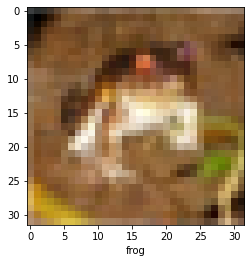

In [73]:
# training data is balanced
# look at quantity of training and test data:
print(f'training shape: {train_data.shape}, type: {train_data.dtype}')
print(f'test shape: {test_data.shape}, type: {test_data.dtype}')

# check the label matches the training image:
plt.imshow(train_data[0,:,:,:])
plt.xlabel(labels[train_labels[0][0]])
plt.show()

In [74]:
# set up categorical labels
n_classes = np.unique(test_labels).shape[0]
Y_test = to_categorical(test_labels, n_classes)
Y_train = to_categorical(train_labels, n_classes)

We now define some training and visualisation functions:

In [75]:
#view training history (loss and accuracy) as graphs
def show_training_history(history):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].legend(['train', 'validation'])
    ax[1].set_xlabel('epoch')
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'])
    plt.show()

In [77]:
# to train the model, we started with a small model and refined it iteratively,
# applying a standard set of techniques:
# image augmentation, input data normalisation, adding layers to the network etc.
# evidence for this is in the tensorboard logs (attached)
# we started with an architecure similar to alexNet then removed layers and modified architecture as required
def train_model(train_data, Y_train, test_data, Y_test, n_classes):
    #set up image augmentation and normalisation
    #do it this way so that it makes efficient use of the GPU if available
    train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1)
    train_gen = train_datagen.flow(train_data, Y_train)

    #repeat for validation data
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_gen = val_datagen.flow(test_data, Y_test)

    # define our model
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=test_data.shape[1:], activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    # alexnet doesn't have intervening pooling/ norm layers here
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu')) 
    model.add(BatchNormalization())
    
    # add our final layer
    model.add(Dense(n_classes, activation='softmax'))  # softmax is required because each sample is from only one class

    # report our architecture
    model.summary()

    # training
    # choose adam because RMSprop leads to increased training loss at higher epochs.
    # categorical cross entropy chosen for >2 classes classification - requires one hot-encoded labels.
    model.compile(metrics=['accuracy'], loss='CategoricalCrossentropy', optimizer='adam')
    
    # save loss/accuracy logs every epoch for Tensorboard visualisation
    # visualise with %tensorboard --logdir logs/fit
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    #chosen after inspection of previous runs.
    n_epochs = 50
    t_start = time.time()
    history = model.fit(train_gen, validation_data=val_gen, epochs=n_epochs, callbacks=[tensorboard_callback])
    t_end = time.time()
    print(f'training took {round((t_end-t_start))/60} minutes')
    show_training_history(history)
    return model

Visualise training performance:

In [78]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3240), started 19:25:09 ago. (Use '!kill 3240' to kill it.)

In [79]:
# we evaluate on our Keras test set: for this problem, we are interested only in correct classifications (i.e. top-1) 
# and we treat all misclassifications as equal (so false positives and false negatives have the same 'cost')
def evaluate(test_data, Y_test):
    # set up image preprocessing; should match training data
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    test_gen = test_datagen.flow(test_data, Y_test)
    scores = model.evaluate(test_gen)
    print(f'Test loss {scores[0]}, accuracy {scores[1]}')
    return scores


We can now train our model.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)       

1563/1563 [==============================] - 47s 30ms/step - loss: 0.4500 - accuracy: 0.8443 - val_loss: 0.5953 - val_accuracy: 0.8127
Epoch 41/50
1563/1563 [==============================] - 56s 36ms/step - loss: 0.4448 - accuracy: 0.8463 - val_loss: 0.5555 - val_accuracy: 0.8192
Epoch 42/50
1563/1563 [==============================] - 56s 36ms/step - loss: 0.4423 - accuracy: 0.8464 - val_loss: 0.5376 - val_accuracy: 0.8258
Epoch 43/50
1563/1563 [==============================] - 61s 39ms/step - loss: 0.4390 - accuracy: 0.8451 - val_loss: 0.5738 - val_accuracy: 0.8212
Epoch 44/50
1563/1563 [==============================] - 61s 39ms/step - loss: 0.4327 - accuracy: 0.8486 - val_loss: 0.5381 - val_accuracy: 0.8252
Epoch 45/50
1563/1563 [==============================] - 56s 36ms/step - loss: 0.4366 - accuracy: 0.8480 - val_loss: 0.5576 - val_accuracy: 0.8237
Epoch 46/50
1563/1563 [==============================] - 56s 36ms/step - loss: 0.4274 - accuracy: 0.8504 - val_loss: 0.5725 - val_

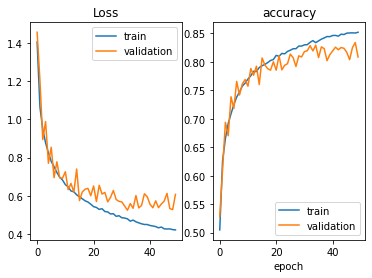

In [82]:
model = train_model(train_data, Y_train, test_data, Y_test, n_classes)

In [84]:
# the unstable validation accuracy and loss would probably need more investigation.
# now save the model:
model.save('model50')

INFO:tensorflow:Assets written to: model50\assets


In [83]:
# get some predictions that we can inspect:
def predict_test(test_data, model):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow(test_data, shuffle=False)
    predictions = model.predict(test_gen)
    sparse_predictions = np.argmax(predictions, axis=1)
    class_predictions = [labels[i] for i in sparse_predictions]
    return class_predictions, sparse_predictions

labelled_predictions, predictions = predict_test(test_data, model)
scores = evaluate(test_data, Y_test)


313/313 [==============================] - 1s 4ms/step - loss: 0.6074 - accuracy: 0.8085
Test loss 0.6073945164680481, accuracy 0.8084999918937683


<AxesSubplot:>

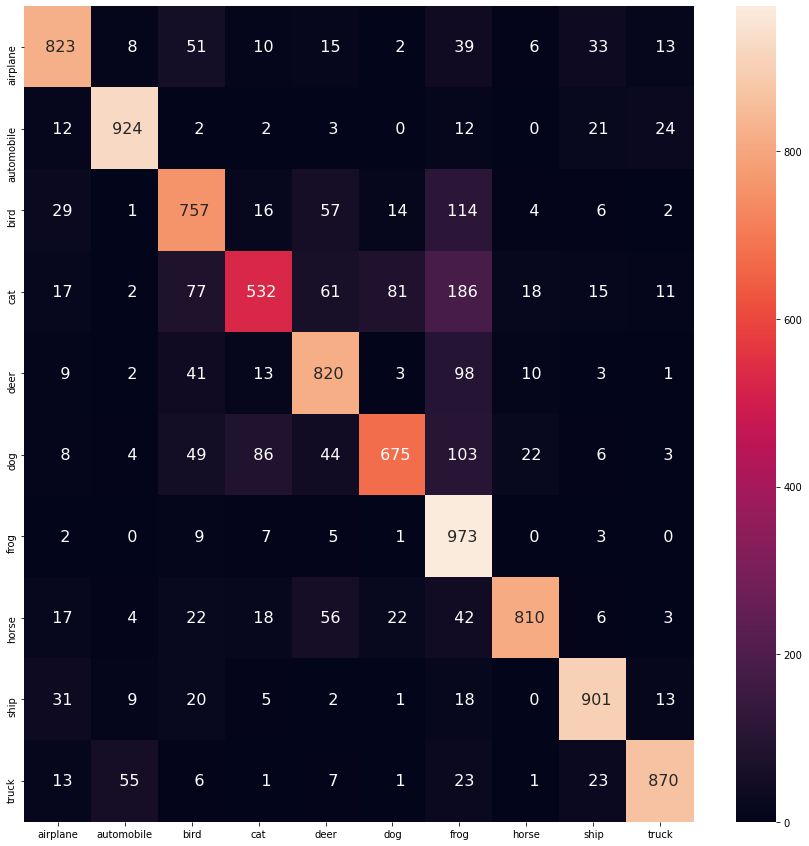

In [85]:
# look at the confusion matrix
confusion = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(15,15))
heatmap(confusion, annot=True, fmt="4d", annot_kws={"size":16}, xticklabels=labels, yticklabels=labels)
#this shows some cat/dog and cat/frog confusion.


We can now evaluate on the Kaggle test set. The Kaggle test set contains an extra 290000 junk images in addition to what we have already seen.



In [86]:
# this assumes the (unlabelled) Kaggle test data exists in a folder 'data/test' and no other folders exist in 'data'
def predict_on_kaggle_test_data(model, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    # Warning! data folder should contain no subfolders except test.
    #TODO check preprocessing conversion.
    final_test_data = datagen.flow_from_directory('data', class_mode=None, shuffle=False, target_size=(32, 32))
    predictions = model.predict(final_test_data, verbose=1)

    # convert predictions matrix to class predictions.
    sparse_predictions = np.argmax(predictions, axis=1)
    class_predictions = [labels[i] for i in sparse_predictions]
    return class_predictions, final_test_data

class_predictions, final_test_datagen = predict_on_kaggle_test_data(model, labels)


Found 300000 images belonging to 1 classes.
9375/9375 [==============================] - 228s 24ms/step


In [87]:
# given the kaggle test results, write them as a CSV so they can be uploaded.
def write_kaggle_csv(class_predictions, datagen, filename='submission_3.csv'):
    all_ids = []
    for i in datagen.index_array:
        # this_pred = class_predictions[i]
        this_id = int(os.path.splitext(os.path.split(datagen.filenames[i])[1])[0])
        all_ids.append(this_id)

    df = pd.DataFrame({'id': all_ids, 'label': class_predictions})
    df.sort_values(by='id', inplace=True)
    df.to_csv(filename, index=False)
    # command: kaggle competitions submit -c cifar-10 -f submission_1.csv -m"final predictions"
    
#the results of this should agree closely with our performance above on the Keras test set.
write_kaggle_csv(class_predictions, final_test_datagen)